# Boohoo Task
## 1. Business Understanding
### 1.1 Business Objectives
You work for an online retailer and your Head of Ecommerce wants to improve conversion rates across the website. She asks you a number of questions to help guide the work:
* What are the current conversion rates by source?
* Is it possible to predict whether a customer is going to make a purchase?
* What are the most important factors driving conversion?
* What should we do next?

## 2. Data
### 2.1 Import libraries
As a goal I always try to automate the repetative parts of tasks like this, so I have a ["useful imports" gist](https://gist.github.com/joezcool02/c98669a3a74a8ae21e5db23b02f6057f)

In [23]:
# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

# Handle table-like data and matrices
import numpy as np
import pandas as pd
from functools import reduce

# Modelling Algorithms
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier, VotingClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC

# Modelling Helpers
from sklearn.preprocessing import Imputer , Normalizer , scale
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFECV
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold, learning_curve

# Visualisation
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import seaborn as sns

# Configure visualisations
%matplotlib inline
mpl.style.use( 'ggplot' )
sns.set_style( 'whitegrid' )
pylab.rcParams[ 'figure.figsize' ] = 8 , 6

### 2.2 Import Helpers

In [24]:
def plot_histograms( df , variables , n_rows , n_cols ):
    fig = plt.figure( figsize = ( 16 , 12 ) )
    for i, var_name in enumerate( variables ):
        ax=fig.add_subplot( n_rows , n_cols , i+1 )
        df[ var_name ].hist( bins=10 , ax=ax )
        ax.set_title( 'Skew: ' + str( round( float( df[ var_name ].skew() ) , ) ) ) # + ' ' + var_name ) #var_name+" Distribution")
        ax.set_xticklabels( [] , visible=False )
        ax.set_yticklabels( [] , visible=False )
    fig.tight_layout()  # Improves appearance a bit.
    plt.show()

def plot_distribution( df , var , target , **kwargs ):
    row = kwargs.get( 'row' , None )
    col = kwargs.get( 'col' , None )
    facet = sns.FacetGrid( df , hue=target , aspect=4 , row = row , col = col )
    facet.map( sns.kdeplot , var , shade= True )
    facet.set( xlim=( 0 , df[ var ].max() ) )
    facet.add_legend()

def plot_categories( df , cat , target , **kwargs ):
    row = kwargs.get( 'row' , None )
    col = kwargs.get( 'col' , None )
    facet = sns.FacetGrid( df , row = row , col = col )
    facet.map( sns.barplot , cat , target )
    facet.add_legend()

def plot_correlation_map( df ):
    corr = full.corr()
    _ , ax = plt.subplots( figsize =( 12 , 10 ) )
    cmap = sns.diverging_palette( 220 , 10 , as_cmap = True )
    _ = sns.heatmap(
        corr, 
        cmap = cmap,
        square=True, 
        cbar_kws={ 'shrink' : .9 }, 
        ax=ax, 
        annot = True, 
        annot_kws = { 'fontsize' : 12 }
    )

def describe_more( df ):
    var = [] ; l = [] ; t = []
    for x in df:
        var.append( x )
        l.append( len( pd.value_counts( df[ x ] ) ) )
        t.append( df[ x ].dtypes )
    levels = pd.DataFrame( { 'Variable' : var , 'Levels' : l , 'Datatype' : t } )
    levels.sort_values( by = 'Levels' , inplace = True )
    return levels

def plot_variable_importance( X , y ):
    tree = DecisionTreeClassifier( random_state = 99 )
    tree.fit( X , y )
    plot_model_var_imp( tree , X , y )
    
def plot_model_var_imp( model , X , y ):
    imp = pd.DataFrame( 
        model.feature_importances_  , 
        columns = [ 'Importance' ] , 
        index = X.columns 
    )
    imp = imp.sort_values( [ 'Importance' ] , ascending = True )
    imp[ : 10 ].plot( kind = 'barh' )
    print (model.score( X , y ))

### 2.3 Read in Data

In [25]:
# Read in full dataset
full = pd.read_csv('../data/raw/raw.csv')

# Check data is read in okay
full.head()

,country,age,new_user,source,total_pages_visited,converted
0,USA,35,1,Ads,4.0,0
1,China,25,1,Direct,5.0,0
2,UK,50,1,Direct,3.0,0
3,China,33,1,Ads,5.0,0
4,USA,38,1,Ads,2.0,0


### 2.4 Statistical summaries
running info and describe give a great insight into our data.

In [26]:
full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500000 entries, 0 to 499999
Data columns (total 6 columns):
country                500000 non-null object
age                    500000 non-null int64
new_user               500000 non-null int64
source                 500000 non-null object
total_pages_visited    500000 non-null float64
converted              500000 non-null int64
dtypes: float64(1), int64(3), object(2)
memory usage: 22.9+ MB


In [27]:
full.describe()

,age,new_user,total_pages_visited,converted
count,500000.000000,500000.000000,5.000000e+05,500000.000000
mean,30.552972,0.685096,-5.518936e+04,0.032310
std,8.278370,0.464478,2.862338e+07,0.176822
min,17.000000,0.000000,-1.759686e+10,0.000000
25%,24.000000,0.000000,2.000000e+00,0.000000
50%,30.000000,1.000000,4.000000e+00,0.000000
75%,36.000000,1.000000,6.000000e+00,0.000000
max,123.000000,1.000000,2.900000e+01,1.000000


### Variable description:
From this very brief investigation we can see that our average users are between the ages of 24-36, 69% of users are new users, and conversion is about 0.03.

There are some issues with this data, we have 123 year olds using the site. There are also a few erroneous total_pages_visited with the value -1759686. These mean before using this data in a model we need to check for outliers, we will come back to this later. To make things a bit more explicit since a couple of the variable names aren't 100% illuminating, here's what we've got to deal with:

### Variable Description
* country: country of traffic origin, one of USA, UK, Germany or China.
* age: a value between 17-123 representing age in years.
* new_user: 1 represents a new_user, 0 a return customer.
* source: The source of the traffice, either Organic, Ads or Direct.
* total_pages_visited: The number of pages the user vists.
* converted: 1 represents the customer converted, 0 they did not.

## 3. Current Conversion Rates by source
The first task is "What are the current conversion rates by source?".
We can take a dataframe of only converted and source since we don't need any other data for this questions.

In [28]:
# Drop redundant columns
df = full[['source', 'converted']]

# Print to check
df.head()

,source,converted
0,Ads,0
1,Direct,0
2,Direct,0
3,Ads,0
4,Ads,0


In [29]:
df['source'].value_counts()

Organic    244967
Ads        140527
Direct     114506
Name: source, dtype: int64

As shown above we have three different source types:
* Organic
* Ads
* Direct

next we can simply group by this column and take the mean conversion.

In [30]:
# group by source, take the mean of conversion
gb_df = df.groupby(['source'])['converted'].mean().to_frame()
gb_df.head()

,converted
source,
Ads,0.034833
Direct,0.028339
Organic,0.032719


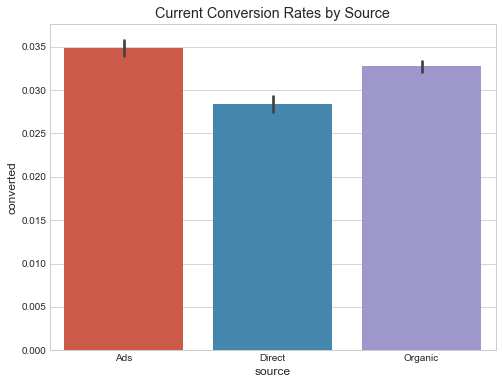

In [31]:
sns.barplot(df['source'], df['converted'], data=gb_df).set_title('Current Conversion Rates by Source');

As you can see above the current conversion rates vary slightly by source. Ad traffic converts the most, then organic traffic, then direct traffic is lowest at the following rates:

* Ads: 0.034833
* Direct: 0.028339
* Organic: 0.032719

### 4. Conversion Prediction
The next question is given the values country, age, new_user, source, total_pages_visited, can we predict conversion?

A great start point is checking a correlation map to see what correlates with conversion.

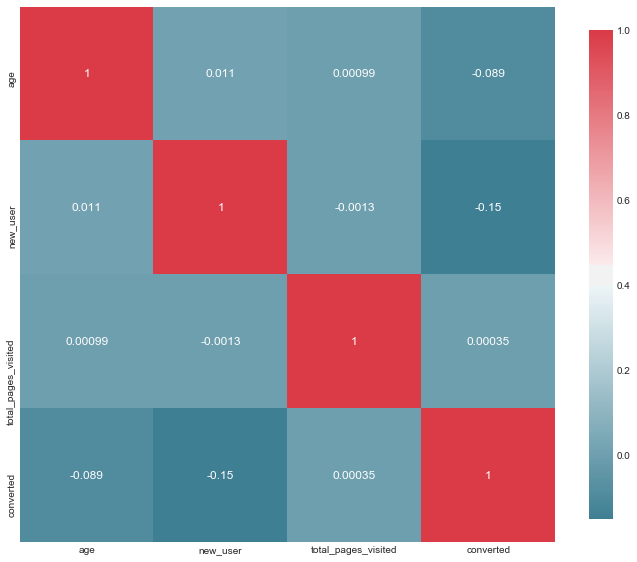

In [32]:
plot_correlation_map(full)

the data as it is hardly correlates with conversion. new_user somewhat negatively correlates with conversion, that is repeat users are more likely to convert as you would expect.

The rest of the features do not correlate, which is good for building a model as correlated features rarely reveal new information.

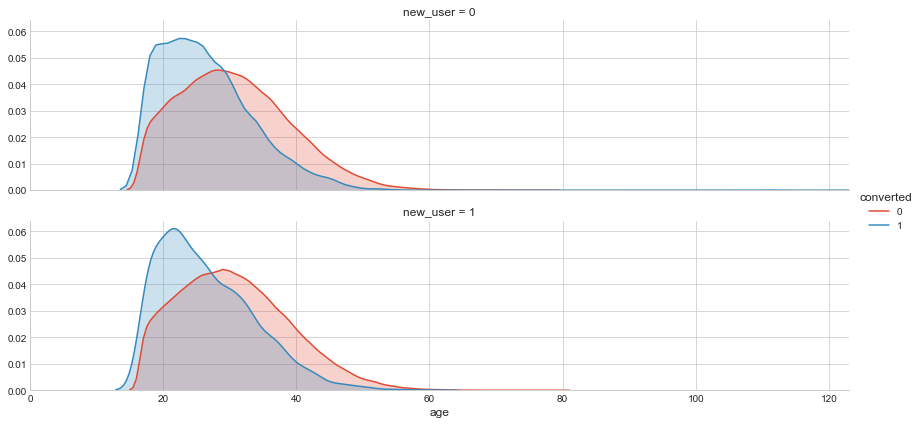

In [33]:
# Plot distributions of Age of users who converted or did not convert, split by new user
plot_distribution( full , var = 'age' , target = 'converted' , row = 'new_user' )

The above data shows that new and young users are most likely to convert.
The peak age of conversion seems to be around and a little above the age of 20.
Young and new users are most likely to convert.

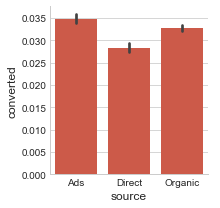

In [35]:
# Plot conversion rate by source
plot_categories( full , cat = 'source' , target = 'converted' )

The above graph is the same as one we have looked at before, showing the varying conversion rates by source.

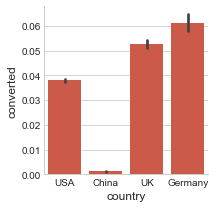

In [36]:
# Plot conversion rate by country
plot_categories( full , cat = 'country' , target = 'converted' )

The above graph shows the variation in conversion rates by the country of traffic. This is very interesting and shows that with the data we have traffic from China is essentially worthless in comparison to European and American traffic. This will be a useful feature when we get to the modeling stage.

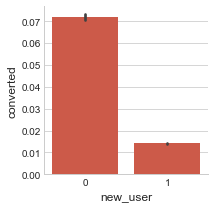

In [37]:
# Plot conversion rate by new_user
plot_categories( full , cat = 'new_user' , target = 'converted' )

The categorical variables look like they will be more useful in a model. old users are much more likely to convert than new users.
somebody

### 4.1 Prep data
There are a few things to do to improve our model:
1. dummy encode country
2. dummy encode source
3. remove age outliers
4. remove invalid total_pages_visited

In [38]:
# dummy encoding ...
countries_df = pd.get_dummies( full['country'] , prefix = 'country_')
full = full.join(countries_df)
full = full.drop(columns=['country'])
full.head()

,age,new_user,source,total_pages_visited,converted,country__China,country__Germany,country__UK,country__USA
0,35,1,Ads,4.0,0,0,0,0,1
1,25,1,Direct,5.0,0,1,0,0,0
2,50,1,Direct,3.0,0,0,0,1,0
3,33,1,Ads,5.0,0,1,0,0,0
4,38,1,Ads,2.0,0,0,0,0,1


In [39]:
# dummy encoding ...
source_df = pd.get_dummies( full['source'] , prefix = 'source_')
full = full.join(source_df)
full = full.drop(columns=['source'])
full.head()

,age,new_user,total_pages_visited,converted,country__China,country__Germany,country__UK,country__USA,source__Ads,source__Direct,source__Organic
0,35,1,4.0,0,0,0,0,1,1,0,0
1,25,1,5.0,0,1,0,0,0,0,1,0
2,50,1,3.0,0,0,0,1,0,0,1,0
3,33,1,5.0,0,1,0,0,0,1,0,0
4,38,1,2.0,0,0,0,0,1,1,0,0


In [40]:
# now we can remove invalid total_pages_visited
full = full[full['total_pages_visited'] > 0]

In [41]:
# 99.9th quantile is age 60
full = full[full['age'] < 60]

In [42]:
full.to_csv('../data/processed/processed.csv')

Now we are ready to split the data and apply some models. I will do Task 4 in a seperate notebook.

In [43]:
train, test = train_test_split(full)

train_X = train.drop(columns=['converted'])
train_y = train.converted
test_X = test.drop(columns=['converted'])
test_y = test.converted

# check sizes
print (full.shape , train_X.shape , test_X.shape , train_y.shape , test_y.shape)

(467352, 11) (350514, 10) (116838, 10) (350514,) (116838,)


## 5. Variable Importance
As you can see below the most powerful factor that affects conversion is the number of pages visited, the more pages visited the more likely the user converts.
Some other important features:
* age: 24-36 year olds are most likely to convert.
* country_China: Traffic from China is much less likely to convert.
* new_user: new users are three times more/less likely to convert.

0.9870818284005775


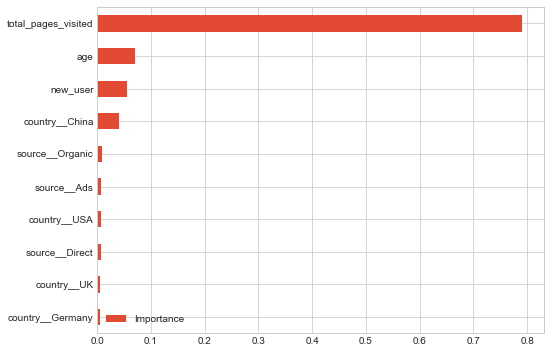

In [44]:
# through investigation indrecitly answering task 3
plot_variable_importance(train_X, train_y)

## 6. What should we do next?
If we have a team of people that can take this model and apply it to the live environment we could predict a users chance to convert mid-journey.

The question here is how we can improve the user experience or further monetize these users.

Some ideas are:
* increase the number of adverts shown to users who we are confident will not convert. Conversely you could reduce the number of ads shown to users with a high chance of conversion to make them feel more trusting of the site.

* implement some A/B tests to see how these seperate groups respond to increased sales. Can we do something to encourage these failures to convert?

* would be awesome to see the split of ad traffic better, could we get keywords? I have done a project MLWords at Laterooms where we automated a campaign and its bidding process.

Also on top of this there are some improvements to the model, we could probably gain another 5% f1 score:
* I only used 2-folds, we could improve on this if i had more time/computing power.
* I only tried a handful of algorithms, and performed very limited hyper paremeter optimization which could also be improved.
* The feature engineering was incredibly limited, there was not much extra to infer from the data we already have.
* actual outlier detection instead of the naive appraoch taken here, tukey method.